In [200]:
import os
import numpy as np
import random
import copy
from collections import defaultdict, namedtuple
os.chdir("/Users/davidamat/Documents/projects/2048/")

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
import matplotlib.pyplot as plt

In [8]:
import sys

sys.path

['/Users/davidamat/Documents/projects/2048/src',
 '/Users/davidamat/Documents/projects/2048/src',
 '/Users/davidamat/Documents/Glovo/missing-items-pipeline',
 '/Users/davidamat/opt/anaconda3/lib/python38.zip',
 '/Users/davidamat/opt/anaconda3/lib/python3.8',
 '/Users/davidamat/opt/anaconda3/lib/python3.8/lib-dynload',
 '',
 '/Users/davidamat/.local/share/virtualenvs/2048-TNu5m-4D/lib/python3.8/site-packages',
 '/Users/davidamat/.local/share/virtualenvs/2048-TNu5m-4D/lib/python3.8/site-packages/IPython/extensions',
 '/Users/davidamat/.ipython']

In [9]:
from common import constants as c

In [169]:
class Movements():
    
    @staticmethod
    def displacement_numbers(mat):
        """
        Desplaza todos los numeros a la izquierda de la matriz
        """
        
        new = np.zeros(mat.shape) # crea una matrix de 0 de AxA (donde A es la c.GRID_LEN)
        done = False
        for i in range(c.GRID_LEN):
            count = 0
            for j in range(c.GRID_LEN):
                # Si en esa fila hay un elemento no nulo
                if mat[i][j] != 0:
                    # Pone ese elemento en la posicion count (columna), donde esta vendra determinada por si
                    # en esa fila, previamente, hemos encotrado algun otro elemento NO nulo
                    new[i][count] = mat[i][j]

                    # Solo con que modifiquemos la posicion de una de los numeros, ya contara como un movimiento: done = True
                    if j != count:
                        done = True

                    # Suma al count una posicion ya que ya se ha movido a la izquerda de todo (columna 0) ese elemento
                    count += 1
        return (new, done)
    
    @staticmethod
    def merge_numbers(mat, game_score = 0):
        """
        Suma los números de cada fila que sean iguales 
        y consecutivos, dejando el segundo sumando a 0
        """
        done = False
        for i in range(c.GRID_LEN):
            for j in range(c.GRID_LEN-1): # la ultima columna j, no tiene una columna a su derecha (j+1)
                celda = mat[i][j]
                celda_derecha = mat[i][j+1]
                if celda == celda_derecha and celda != 0: # si son iguales, y esta igualdad son numeros > 0, se suman
                    merge_val = celda + celda_derecha
                    mat[i][j] = merge_val
                    game_score += merge_val #suma los puntos
                    mat[i][j+1] = 0 # se deja la de la derecha vacía, esto hace que se necesite hacer otro displacement para llenar ese hueco
                    # esto tambien hace que al leer la siguiente columna, se lea un 0, y no el numero que estaba
                    done = True
        return (mat, done, game_score)
    
    @staticmethod
    def perform_movement(game, game_score):
        """
        1 - mover al maximo a la izquierda todos los numeros
        2 - Sumamos los iguales dejando 0 en el segundo sumando
        3 - Por seguridad, por si hemos dejado alguno sin desplazar a la izquierda (huecos generados por el merge),
            se vuelve a aplicar sin importar el done o no (no importa si mueve a alguien o no ahora)
        """
        game_disp, done_disp = Movements.displacement_numbers(game)
        game_merged, done_merge, game_score = Movements.merge_numbers(game_disp, game_score)
        game_final = Movements.displacement_numbers(game_merged)[0]
        return (game_final, done_disp or done_merge, game_score)
    
    @staticmethod
    def ro(mat, cw = True, num = 1): #cw: clockwise: True or False, #num: number of rotations
        """
        Rota 90º las matrices para que las operaciones UP, DOWN y RIGHT se puedan hacer con la de LEFT
        """
        param_clockise = (1,0) if cw else (0,1) #clockwise or counter-clockwise (see help(np.rot90))

        # Cuantas rotaciones hacemos
        rot_mat = mat
        for _ in range(num):
            rot_mat = np.rot90(np.array(rot_mat), axes = param_clockise)

        return rot_mat

    @staticmethod
    def left(game, game_score = 0):
        return Movements.perform_movement(game, game_score)
    
    @staticmethod
    def down(game, game_score = 0):
        """
        C - L - UC
        """
        rotate_game = Movements.ro(game) #rotate clockwise
        left_game, done, game_score = Movements.left(rotate_game, game_score) #apply left
        game_final = Movements.ro(left_game, cw = False) #undo the rotation
        return game_final, done, game_score
    
    @staticmethod
    def up(game, game_score = 0):
        """
        UC - L - C
        """
        rotate_game = Movements.ro(game, cw = False) #rotate anti-clockwise
        left_game, done, game_score = Movements.left(rotate_game, game_score) #apply left
        game_final = Movements.ro(left_game) #undo the rotation
        return game_final, done, game_score

    @staticmethod
    def right(game, game_score = 0):
        """
        C - C - L - UC - UC
        """
        rotate_game = Movements.ro(game,cw=True, num =2) #double rotation
        left_game, done, game_score = Movements.left(rotate_game, game_score) #apply left
        game_final = Movements.ro(left_game, cw = False, num = 2) #undo the rotation
        return game_final, done, game_score

    

In [170]:
class Env():
    
    def __init__(self, grid_size):
        """
        grid_size: size of the matrix
        """
        # Status
        self.game_stat = -2 # 0: playing, 1: win, -1: lost, -2: ready to start
        
        # Actions
        self.actions = {0: Movements.up, 
                        1: Movements.down, 
                        2: Movements.left, 
                        3: Movements.right}
        
        # Log in a list all the matrices in each step
        self.log = defaultdict(list)
        
        # Initialize matrix
        self._init_matrix(grid_size)
        
        # Score accumulated
        self.game_score = 0
    
        
    def _init_matrix(self, n):
        """
        Initializes the game matrix
        """
        self.matrix = np.zeros((n,n))
        self._add_two(times = 2)
        
        # Log
        self.log["mat"].append(self.matrix)
        self.log["action"].append(-1) # randomly added action
        self.log["reward"].append(0)
        
    def _add_two(self, times,  choices = c.RANDOM_NUMBER_CHOICES, probs_choices = c.PROBAB_NUMBER_CHOICES):
        """
        Add to the matrix randomly a 2 and 4
        """
        for _ in range(times):
            # choose only cells with a 0
            avail_cells = list(zip(*np.where(self.matrix==0)))
            
            # Choose the new index of the matrix
            index_sample = random.sample(avail_cells, 1)[0]
            
            # Start the game always with a 2
            if self.game_stat == -2:
                self.matrix[index_sample] = 2
                
                # Change the stat to playing
                self.game_stat = 0
            
            elif len(avail_cells):
                # Choose randomly between a 2 or a 4 and put it in the matrix
                value_sample = np.random.choice(choices, p = probs_choices)
                self.matrix[index_sample] = value_sample
            else:
                sys.exit("Finished game!")
                
    def _check_possible_action(self):
        """
         # Check if there is any possible action to take
         without modifying the env matrix
        """
        any_action_available = False
        test_matrix = copy.copy(self.matrix)
        for a_id in self.actions:
            _, action_available, _ = self.actions[a_id](test_matrix, 0)
            any_action_available |= action_available
        return any_action_available
        
        
                
    def _game_stat(self):
        """
        Status of the game:
        1: game won
        -1: game lost
        0: game in play
        """            
        if self.matrix.min() == 0:
            if self.matrix.max() >= c.OBJECTIVE:
                self.game_stat = 1
            else:
                self.game_stat = 0
        else:
            if self._check_possible_action():
                self.game_stat = 0
            else:
                self.game_stat = -1
                
        
                
    # Play step
    def step(self, action_id):
        """
        Returns:
        - start matrix
        - final matrix
        - has_moved: if the action taken has lead to a movement (True) or not (False)
        - reward
        - game stat
        """
        
        # Take the action
        start_matrix = copy.copy(self.matrix)
        self.matrix, done, reward = self.actions[action_id](self.matrix)
        self.game_score += reward
        
        # Log
        self.log["mat"].append(self.matrix)
        self.log["action"].append(action_id)
        self.log["reward"].append(reward)
        
        # If the movement could be done
        if done: 
            # Add randomly the next number in the matrix
            self._add_two(times = 1)
            
            # Log
            self.log["mat"].append(self.matrix)
            self.log["action"].append(-1) #action -1 is a randomly added number
            self.log["reward"].append(0)
            
            # Check game status if a further action is possible
            self._game_stat()
        
        # If the movement performed didn't change anything keep playing
        return start_matrix, self.matrix, done, reward, self.game_stat
    
    # Reset
    def reset(self):
        self.__init__(self.matrix.shape[0])

In [171]:
class Player():
    
    def __init__(self, env):
        self.env = env
        self.steps = 0
        self.game_stat = 0
        self.log = defaultdict(list)
    
    def play_random(self):
        
        while self.game_stat == 0:
            self.steps += 1
            
            # action random
            action_pl = np.random.choice(list(self.env.actions.keys()))
            
            #choose a random action
            start_matrix, end_matrix, done, reward, self.game_stat = self.env.step(action_pl)
            
            # log
            self.log["mat_o"].append(start_matrix)
            self.log["action"].append(action_pl)
            self.log["reward"].append(reward)
            self.log["mat_f"].append(end_matrix)
            self.log["done"].append(done)
            self.log["game_stat"].append(self.game_stat)

In [302]:
class Model(nn.Module):
    def __init__(self, input_size, n_actions):
        super(Model, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        
        self.apply(self._init_weights)

    def forward(self, x):
        """
        Assumes x is the input matrix of the board
        """
        return self.net(x)
    
    def _init_weights(self, m):
        """
        Initializes all weights and biases to the same quantity
        to avoid initially getting stucked into a action value
        when the network is just exploring and taking the same step
        which may lead the matrix in the same corner without moving
        until another action is sampled.
        """
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.4)

In [357]:
class PolicyAgent():
    """
    Policy agent gets action probabilities from the model and samples actions from it
    """
    # TODO: unify code with DQNAgent, as only action selector is differs.
    def __init__(self, model, device="cpu"):
        self.model = model
        self.device = device        
        
    def preprocess(self, state):
        return torch.tensor(state.ravel(), dtype = torch.float)
    
    def action_selector(self, probs, epsilon = 0):
        """
        :param epsilon: probability to switch from a random chosen action and the policy-based action
        """
        assert isinstance(probs, np.ndarray)
        if (epsilon > 0) & (np.random.rand() < epsilon):
            # take a random choice
            return np.random.choice(probs.shape[0]) 
        else:
            return np.random.choice(probs.shape[0], p=probs)

    
    @torch.no_grad()
    def __call__(self, state):
        """
        Return actions from given a state
        :param states: list of states
        :return: list of actions
        """
        state = self.preprocess(state).to(self.device)
        probs = F.softmax(self.model(state) ,dim=0).data.cpu().numpy()
        return self.action_selector(probs)

In [304]:
c.GRID_LEN = 4
c.OBJECTIVE = 256

#env = Env(c.GRID_LEN)
#pl = Player(env)
#pl.play_random()

env = Env(c.GRID_LEN)
model = Model(c.GRID_LEN**2, len(env.actions))
agent = PolicyAgent(model = model)

In [359]:
class EpsilonPolicy():
    """
    Sets a decayment policy of the epsilon for the 
    agent to ignore the policy-based action
    and perform a random action instead
    """
    
    def __init__(self, eps_start, eps_decay, eps_final):
        self.eps_start = eps_start
        self.eps_final = eps_final
        self.eps_decay = eps_decay
    
    def get_epsilon(step):
        self.epsilon = max(self.eps_final, self.eps_start  - step / self.eps_decay)

In [305]:
ExperienceEpisode= namedtuple('ExperienceEpisode', ('state', 'action', 'done', 'reward',  'game_stat'))

class ExperienceSource():
    """
    Helps in the REINFORCE algorithm providing
    - A continuous source of steps for 1 single episode until the buffer gets reset
    - Inputs:
        - env:
        - agent: performs actions based on a policy (REINFORCE -> on-policy)
        - epsilon: at the starting steps, vary between epsilon-greedy and policy based
    Returns:
        - reward: for each step 
        - state: state for each step in the episode
        - action: action decided by the agent to be taken at each step
    
    """
    def __init__(self, env, agent, epsilon):
        self.env = env
        self.agent = agent
        self.history = [] # history of ExperienceSource instances for 1 entire episode
        self.env.reset()

    def populate_episode(self):
        
        # Play until the episode finishes
        game_stat = 0
        while game_stat == 0:
            # use the agent's policy to choose next action
            action_id = self.agent(self.env.matrix)
            
            start_matrix, end_matrix, done, reward, game_stat = self.env.step(action_id)
                
            # fill the history of steps
            self.history.append(ExperienceEpisode(state=start_matrix, action=action_id, done = done, reward=reward, game_stat=game_stat))
            
    def reset(self):
        self.env.reset()
        self.history = []

In [306]:
env = Env(c.GRID_LEN)
model = Model(c.GRID_LEN**2, len(env.actions))
eps = EpsilonPolicy(eps_start=1, eps_final=0.3, eps_dec)
agent = PolicyAgent(model = model)
exp = ExperienceSource(env, agent)

In [307]:
%%time
exp.populate_episode()

CPU times: user 12.4 s, sys: 29.3 ms, total: 12.4 s
Wall time: 12.4 s


In [309]:
actions = [ss.action for ss in exp.history]

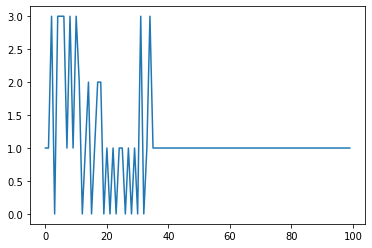

In [314]:
plt.plot(actions[:100])

In [315]:
exp.history[30:45]

[ExperienceEpisode(state=array([[ 0.,  0.,  4.,  0.],
        [ 8.,  2.,  2.,  4.],
        [16.,  8.,  4.,  8.],
        [ 2.,  2., 16.,  4.]]), action=0, done=True, reward=0, game_stat=0),
 ExperienceEpisode(state=array([[ 8.,  2.,  4.,  4.],
        [16.,  8.,  2.,  8.],
        [ 2.,  2.,  4.,  4.],
        [ 0.,  0., 16.,  2.]]), action=3, done=True, reward=20.0, game_stat=0),
 ExperienceEpisode(state=array([[ 0.,  8.,  2.,  8.],
        [16.,  8.,  2.,  8.],
        [ 4.,  0.,  4.,  8.],
        [ 0.,  0., 16.,  2.]]), action=0, done=True, reward=36.0, game_stat=0),
 ExperienceEpisode(state=array([[16., 16.,  4., 16.],
        [ 4.,  0.,  4.,  8.],
        [ 0.,  0., 16.,  2.],
        [ 0.,  4.,  0.,  0.]]), action=1, done=True, reward=8.0, game_stat=0),
 ExperienceEpisode(state=array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  4., 16.],
        [16., 16.,  8.,  8.],
        [ 4.,  4., 16.,  2.]]), action=3, done=True, reward=56.0, game_stat=0),
 ExperienceEpisode(state=array([[ 

In [321]:
model()

tensor([ 1.0507, 12.3679,  3.4345,  1.6819], grad_fn=<AddBackward0>)

In [327]:
a1 = model(agent.preprocess(np.array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  4.,  4.],
        [ 0.,  0., 32., 32.],
        [ 2.,  8., 16.,  2.]])))

In [329]:
probs = F.softmax(a1, dim = 0).detach().numpy()

In [330]:
probs

array([1.2159323e-05, 9.9983299e-01, 1.3188559e-04, 2.2857925e-05],
      dtype=float32)

In [326]:
model

Model(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)